In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.image_analysis import *
from core.utils.basic_functions import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import mat73
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
import matplotlib.image as mpimg
from PIL import Image
from scipy import stats, ndimage
from torchvision.utils import make_grid
from datetime import datetime, timedelta


In [2]:
data_root = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data"


animal_name = "Caos"
server_init = r"N:\PonceLab"
save_root = os.path.join(r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results", f'fingerprint_exp_{animal_name}')
os.makedirs(save_root, exist_ok=True)

# Define the paths to the data
select_exp_path = os.path.join(data_root, "selectivity", f"select_fingerprint_{animal_name}")
# List .mat files in each directory
select_exp_files = list_mat_files(select_exp_path)


In [ ]:
# print all unique images unique_nam

In [3]:
sei = 2
select_data = load_mat_data(os.path.join(select_exp_path, select_exp_files[sei]))
# in the select_data[.all_imgased_name'] we have big lest of nonuinqe name, I want a id for each unique name to eah indec of the list
unique_names = np.unique(select_data['all_images_name'])
name2id = dict(zip(unique_names, range(len(unique_names))))
select_data['all_img_ids'] = np.array([name2id[name] for name in select_data['all_trials_image']])
# if the name of the image have the one one of the following words, assign it to the corresponding category
# kitchen, elephant, monkey,anvil, birdhouse, pumpkin, hay, silverfish, extinguisher. 
# otherwise assign it to the category 'other'
categories = ['kitchen', 'elephant', 'monkey', 'anvil', 'birdhouse', 'pumpkin', 'hay', 'silverfish', 'extinguisher']
category2id = {}
for cat in categories:
    category2id[cat] = len(category2id)
category2id['other'] = len(category2id)
id2category = {v: k for k, v in category2id.items()}
# the name of images are long but they contain the category name, so we can use this to assign the category. Then we need cheach which category name present in the image name or not. 
# however, if it not present in the image name, we assign it to the category 'other'
select_data['all_img_category'] = np.array([ np.array([cat in name for cat in categories]).argmax() if any([cat in name for cat in categories]) else category2id['other'] for name in select_data['all_trials_image']])

# let make the images labels vector (y) and the coresponding responce of each neurons that gonna shape num_of_images * unm_of_neurons matrix (X);
# for the all the images that fall in one category except the 'other' category. the responce is stored in the 'evoke_resp' field of the select_data
indexes_filter = select_data['all_img_category'] != category2id['other']
images_category_labels_y = select_data['all_img_category'][indexes_filter]
images_category_resp = select_data['evoke_resp'][:, indexes_filter]
# let traspsoe the responce matrix to have the shape of num_of_images * num_of_neurons
images_category_resp_X = images_category_resp.T
## 
# now let get the mask for the neurons are, which can be featch from the select_data['spikeID'] 
# and we should following this:
if animal_name == 'Caos':
    v1_border = 32
    v4_border = 64
    it_border = 96
elif animal_name == 'Diablito':
    v1_border = 16
    v4_border = 32
    it_border = 64
else:
    raise ValueError('The animal name is not valid')
# the mask for the neurons in the V1, V4, and IT
v1_mask = select_data['spikeID'] < v1_border
v4_mask = (select_data['spikeID'] >= v1_border) & (select_data['spikeID'] < v4_border)
it_mask = select_data['spikeID'] >= v4_border

# let get the responce of the neurons in each area
v1_category_resp_X = images_category_resp_X[:, v1_mask]
v4_category_resp_X = images_category_resp_X[:, v4_mask]
it_category_resp_X = images_category_resp_X[:, it_mask]

# Calculate F-values and p-values for each neuron using one-way ANOVA
def calculate_f_p_values(resp_matrix, labels):
    f_values = np.zeros(resp_matrix.shape[1])
    p_values = np.zeros(resp_matrix.shape[1])
    for i in range(resp_matrix.shape[1]):
        f_values[i], p_values[i] = stats.f_oneway(*[resp_matrix[labels == category, i] for category in np.unique(labels)])
    return f_values, p_values

v1_f_values, v1_p_values = calculate_f_p_values(v1_category_resp_X, images_category_labels_y)
v4_f_values, v4_p_values = calculate_f_p_values(v4_category_resp_X, images_category_labels_y)
it_f_values, it_p_values = calculate_f_p_values(it_category_resp_X, images_category_labels_y)

# let get decoding accuracy for the category labels using the responce of the 5, 10, 15, ... neurons in each area
# using cross-validation with 5 folds (sshuffle=True) and svm classifier with linear kernel using the sklearn library

# Calculate decoding accuracy using SVM with cross-validation
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold


def calculate_decoding_accuracy(resp_matrix, labels, step=5):
    accuracies = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for num_neurons in range(step, resp_matrix.shape[1] + 1, step):
        svc = SVC(kernel='linear')
        scores = cross_val_score(svc, resp_matrix[:, :num_neurons], labels, cv=skf)
        accuracies.append((num_neurons, scores.mean()))
    return accuracies


def calculate_decoding_accuracy(resp_matrix, labels, step=5, repeats=3):
    accuracies = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    num_neurons_range = range(step, resp_matrix.shape[1] + 1, step)
    for num_neurons in num_neurons_range:
        repeat_accuracies = []
        for _ in range(repeats):
            selected_neurons = np.random.choice(resp_matrix.shape[1], num_neurons, replace=False)
            svc = SVC(kernel='linear')
            scores = cross_val_score(svc, resp_matrix[:, selected_neurons], labels, cv=skf)
            repeat_accuracies.append(scores.mean())
        accuracies.append((num_neurons, np.mean(repeat_accuracies)))
    return accuracies


v1_accuracies = calculate_decoding_accuracy(v1_category_resp_X, images_category_labels_y)
v4_accuracies = calculate_decoding_accuracy(v4_category_resp_X, images_category_labels_y)
it_accuracies = calculate_decoding_accuracy(it_category_resp_X, images_category_labels_y)

In [6]:
it_accuracies_flat = [acc[1] for acc in it_accuracies]
v4_accuracies_flat = [acc[1] for acc in v4_accuracies]
v1_accuracies_flat = [acc[1] for acc in v1_accuracies]
num_neurons_range_v1 = [acc[0] for acc in v1_accuracies]
num_neurons_range_v4 = [acc[0] for acc in v4_accuracies]
num_neurons_range_it = [acc[0] for acc in it_accuracies]

In [11]:
len(np.unique(images_category_labels_y))

9

Text(0.5, 1.0, 'Decoding accuracy using SVM')

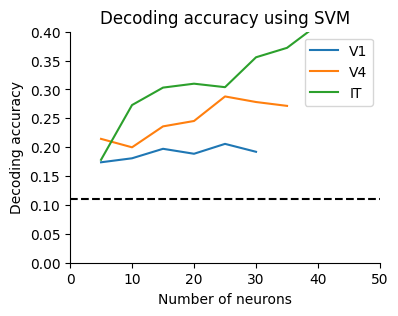

In [9]:
# let plot the results all in one figure
plt.figure(figsize=(4, 3))
plt.plot(num_neurons_range_v1, v1_accuracies_flat, label='V1')
plt.plot(num_neurons_range_v4, v4_accuracies_flat, label='V4')
plt.plot(num_neurons_range_it, it_accuracies_flat, label='IT')
plt.xlabel('Number of neurons')
plt.ylabel('Decoding accuracy')
plt.ylim(0, .4)
plt.xlim(0, 50)
plt.legend()
# add the cghance level line wich is 1/number_of_categories
plt.axhline(1 / len(np.unique(images_category_labels_y)), color='black', linestyle='--')
plt.title('Decoding accuracy using SVM')